# Soft Actor-Critic
### Implementation using Equinox

Temporal file (backup)

In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import jax

from src.systems.linear import StochasticDoubleIntegrator
from src.RL.PolicyGradient.SoftActorCritic.main import *

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
seed = 0
T = 200

key = jrandom.PRNGKey(seed)

x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0, boundary=5)

n_actions, n_controls, n_hidden = 2, 1, 32

SAC = SoftActorCritic(n_actions, n_controls, key)
SAC.SVF.eta = 1e-2
SAC.SQF_1.eta = 1e-2
SAC.SQF_2.eta = 1e-2
SAC.PI.eta = 1e-1
key0, key1, key2, key3, key = jrandom.split(key, 5)

buffer_size, state_dim, action_dim = 100, 2, 1

time_horizon = jnp.arange(0, T, SDI.dt)
for t in time_horizon:
    s0_estimate = SDI.observe(key0)
    control, _ = SAC.get_control(s0_estimate, key1)
    _, cost, done = SDI.update(key2, control, info=True)
    s1_estimate = SDI.observe(key3)

    state_transition = (s0_estimate, control, -cost, s1_estimate)
    SAC.update(state_transition, key)

    # step
    key0, key1, key2, key3, key = jrandom.split(key, 5)

    if done:
        x0 = jrandom.normal(key, (2,))*2
        SDI.reset(x0)



KeyboardInterrupt: 

In [10]:
#SAC.tracker.memory['state0']


DeviceArray(1.1178762, dtype=float32)

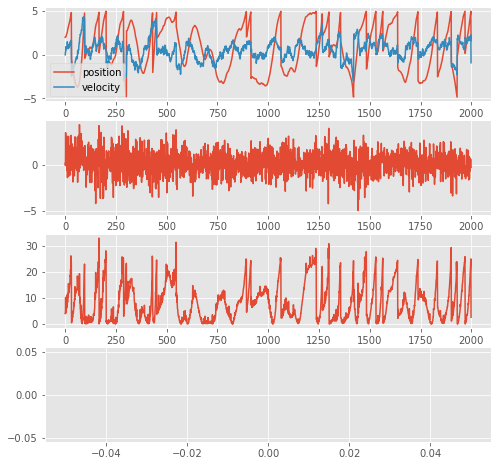

In [4]:
TH = time_horizon
TK = SAC.tracker.memory


labels = {'y':[None, 'control', 'angle', 'cost']}
fig, ax = plt.subplots(4, figsize=(8, 8))
ax[0].plot(TK['state0'], label='position')
ax[0].plot(TK['state1'], label='velocity')
ax[0].legend()
ax[1].plot(TK['control'])
ax[2].plot(TK['cost'])
ax[3].plot(TK['policy_force'])


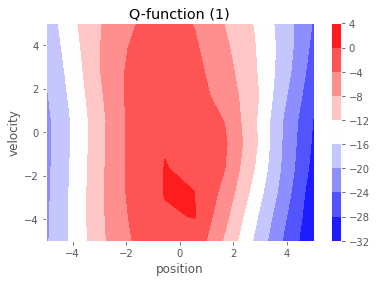

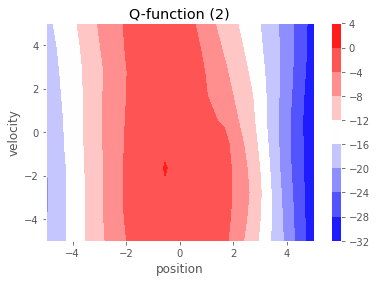

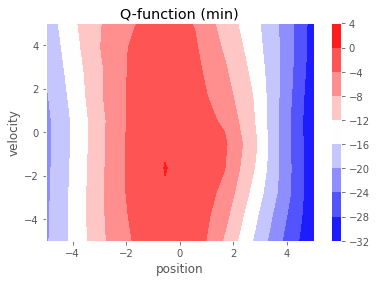

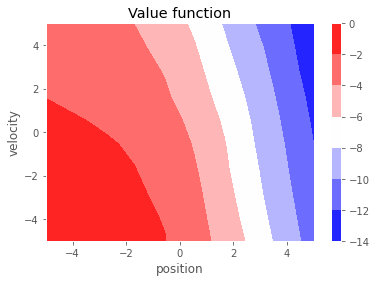

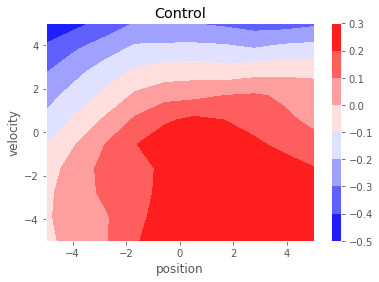

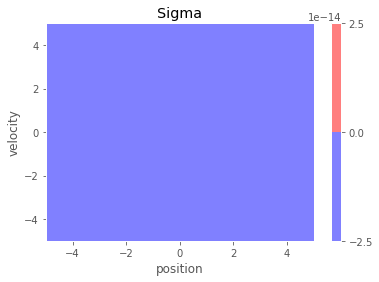

In [5]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
zv = np.zeros((n, n))
zq = np.zeros((n, n))
zq1 = np.zeros((n,n))
zq2 = np.zeros((n,n))
zu = np.zeros((n, n))
zsig = np.zeros((n, n))

Nu = 20
u_space = np.linspace(-5, 5, Nu)
Q = np.zeros(((n,n,Nu)))

for i in range(n):
    for j in range(n):
        for k in range(Nu):
            u = u_space[k]
            q1_val = SAC.SQF_1.predict(jnp.array([xv[i,j], yv[i,j]]), u)
            q2_val = SAC.SQF_2.predict(jnp.array([xv[i,j], yv[i,j]]), u)
            Q[i,j,k] = min(q1_val, q2_val)
        v_val = SAC.SVF.predict(jnp.array([xv[i,j], yv[i,j]]))
        q1_val = SAC.SQF_1.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        q2_val = SAC.SQF_2.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        q_val = min(q1_val, q2_val)
        u_val, sigma = SAC.PI.model(jnp.array([xv[i,j], yv[i,j]]))
        #_, u_val = SAC.get_control(jnp.array([xv[i,j], yv[i,j]]))
        zv[i,j] = v_val
        zu[i,j] = u_val
        zq[i,j] = q_val
        zq1[i,j] = q1_val
        zq2[i,j] = q2_val

plt.contourf(xv, yv, zq1, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (1)')
plt.show()

plt.contourf(xv, yv, zq2, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (2)')
plt.show()

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (min)')
plt.show()

plt.contourf(xv, yv, zv, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control')
plt.show()

plt.contourf(xv, yv, zsig, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Sigma')
plt.show()



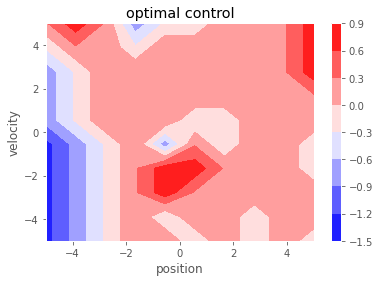

In [5]:
Q_idx = np.argmax(Q, axis=2)
Qu = np.zeros_like(Q_idx, dtype=np.float32)
for i, row in enumerate(Q_idx):
    for j, item in enumerate(row):
        Qu[i,j] = u_space[item]

plt.contourf(xv, yv, Qu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('optimal control')
plt.show()